In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import datetime
import os 


def normalize(v):
    return v / np.linalg.norm(v, axis=-1, keepdims=True)

def log_map(x, y):
    """Log map on the sphere: maps y to tangent space at x"""
    dot = np.sum(x * y, axis=-1, keepdims=True)
    theta = np.arccos(np.clip(dot, -1.0, 1.0))
    sin_theta = np.sin(theta)
    direction = y - dot * x
    direction = np.where(sin_theta == 0, 0, direction / sin_theta)
    return theta * direction

def exp_map(x, v):
    """Exp map on the sphere: maps vector in tangent space at x to the sphere"""
    norm_v = np.linalg.norm(v, axis=-1, keepdims=True)
    norm_v = np.where(norm_v == 0, 1, norm_v)  # prevent division by 0
    return normalize(np.cos(norm_v) * x + np.sin(norm_v) * v / norm_v)


def parallel_transport_sphere(x, y, v):
    """
    Parallel transport of tangent vector v from x to y on the unit sphere.

    Parameters:
    - x: base point on sphere (shape: (d,))
    - y: destination point on sphere (shape: (d,))
    - v: tangent vector at x (shape: (d,), must satisfy dot(x, v) = 0)

    Returns:
    - transported vector in T_y(S^{d-1})
    """
    x = x / np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    dot_xy = np.dot(x, y)

    if np.abs(dot_xy + 1) < 1e-6:
        raise ValueError("x and y are antipodal; parallel transport is not uniquely defined.")

    coeff = np.dot(v, y) / (1 + dot_xy)
    transported = v - coeff * (x + y)
    
    # Ensure result is in tangent space at y
    transported -= np.dot(transported, y) * y
    return transported

def sample_uniform_tangent_vector(x, r):
    """
    Sample uniformly from the ball of radius r in the tangent space T_x(S^{n-1}).

    Parameters:
    - x: point on the unit sphere (shape: (n,))
    - r: radius of the ball in the tangent space

    Returns:
    - v: vector in T_x(S^{n-1}) with norm <= r
    """
    n = x.shape[0]

    # Step 1: Sample random vector from standard normal
    z = np.random.randn(n)

    # Step 2: Project onto tangent space at x
    v = z - np.dot(z, x) * x

    # Step 3: Normalize and scale
    norm_v = np.linalg.norm(v)
    if norm_v < 1e-10:
        return sample_uniform_ball_tangent_space(x, r)  # Retry if projection is numerically unstable
    v_unit = v / norm_v

    # Step 4: Sample radius for uniform ball (not just sphere)
    radius = r * np.random.rand()**(1.0 / (n - 1))
    return radius * v_unit

def sample_uniform_ball_tangent_space(x, r):
    """
    Sample uniformly from the ball of radius r in the tangent space T_x(S^{n-1}).

    Parameters:
    - x: point on the unit sphere (shape: (n,))
    - r: radius of the ball in the tangent space

    Returns:
    - v: vector in T_x(S^{n-1}) with norm <= r
    """
    n = x.shape[0]

    # Step 1: Sample random vector from standard normal
    z = np.random.randn(n)

    # Step 2: Project onto tangent space at x
    v = z - np.dot(z, x) * x

    # Step 3: Normalize and scale
    norm_v = np.linalg.norm(v)
    if norm_v < 1e-10:
        return sample_uniform_ball_tangent_space(x, r)  # Retry if projection is numerically unstable
    v_unit = v / norm_v

    # Step 4: Sample radius for uniform ball (not just sphere)
    radius = r * np.random.rand()**(1.0 / (n - 1))
    return exp_map(x,radius * v_unit)


def project_onto_geodesic_ball(x, y, r):
    """
    Project y onto the geodesic ball of radius r centered at x on the sphere.

    Parameters:
    - x: center of geodesic ball (on sphere), shape (n,)
    - y: point on the sphere, shape (n,)
    - r: radius in radians (0 < r <= pi)

    Returns:
    - projected point on sphere (shape: (n,))
    """
    x = x / np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    
    dot_xy = np.clip(np.dot(x, y), -1.0, 1.0)
    theta = np.arccos(dot_xy)

    if theta <= r:
        return y  # already in the ball

    # Step 1: compute direction vector in tangent space
    v = y - dot_xy * x
    norm_v = np.linalg.norm(v)
    if norm_v < 1e-10:
        raise ValueError("x and y are (numerically) identical or antipodal; projection undefined.")

    # Step 2: normalize and apply exponential map at radius r
    v_unit = v / norm_v
    return np.cos(r) * x + np.sin(r) * v_unit


Consensus Step

In [2]:
def fr_mean_step(points, W):
    """One consensus step via weighted log map + exponential map"""
    n = len(points)
    updated = []
    for i in range(n):
        logs = np.array([W[i, j] * log_map(points[i], points[j]) for j in range(n)])
        tangent_mean = np.sum(logs, axis=0)
        new_point = exp_map(points[i], tangent_mean)
        updated.append(new_point)
    return np.array(updated)

Frechet mean computation

In [3]:

def compute_frechet_mean(points, max_iter=100, tol=1e-6, step_size=1.0):
    """
    Compute Fréchet mean on the hypersphere using gradient descent.
    points: (n, d) array on the unit sphere
    """
    mean = normalize(np.mean(points, axis=0, keepdims=True))
    logs=np.zeros(points.shape)
    n = points.shape[0]
    d = points.shape[1]
    for _ in range(max_iter):
        for k in range(n):
            logs[k]=log_map(mean,points[k,:])
        # logs = np.array([log_map(mean, p) for p in points])
        grad = np.sum(logs, axis=0)
        update = step_size * grad / len(points)
        mean_new = exp_map(mean, update[np.newaxis, :])
        if np.linalg.norm(mean_new - mean) < tol:
            break
        mean = mean_new
    return normalize(mean)[0].reshape(1,-1)

def geodesic_variance(points, frechet_mean):
    """
    Compute the geodesic variance of points on the sphere relative to the Fréchet mean.
    """
    dots = np.clip(np.sum(points * frechet_mean, axis=-1), -1.0, 1.0)
    dists = np.arccos(dots)
    return np.mean(dists**2)

def compute_variance(points,max_iter=100, tol=1e-6, step_size=1.0):
    frechet_mean = compute_frechet_mean(points,max_iter=max_iter, tol=tol, step_size=step_size)
    return geodesic_variance(points, frechet_mean)


def mean_squared_geodesic_distance(x, points):
    """
    Compute average of squared geodesic distances from x to a set of points on the sphere.

    Parameters:
    - x: base point on the sphere, shape (n,)
    - points: array of points on the sphere, shape (N, n)

    Returns:
    - mean_squared_distance: scalar
    """
    x = x / np.linalg.norm(x)
    points = points / np.linalg.norm(points, axis=1, keepdims=True)

    dots = np.clip(points @ x, -1.0, 1.0)  # inner products
    angles = np.arccos(dots)              # geodesic distances
    return np.mean(angles ** 2)

def geod_dist(x,y):
    dot = np.clip(y.T @ x, -1.0, 1.0)
    return np.arccos(dot)

In [28]:
def sample_gradient_bandit(x,p,delta,dim):
    u = sample_uniform_tangent_vector(x, 1)
    x2= exp_map(x,delta*u)
    x1= exp_map(x,-delta*u)
    g = 0.5*(dim/delta)*(geod_dist(x2,p)-geod_dist(x1,p))*u
    return g

In [40]:
dim =16
delta = np.pi/16
x1 =np.random.randn(dim)
x1 = normalize(x1)

x2 =np.random.randn(dim)
x2 = normalize(x2)

# geod_dist(x1,x2)
u = sample_uniform_tangent_vector(x2, 1)
print(u.T@x2)

g=sample_gradient_bandit(x2,x1,delta,dim)
print(np.linalg.norm(g))

-6.938893903907228e-17
1.6768742362204188


In [347]:
def save_results(config,results):

    data = {'config' : config, 'results' : results}
    date_str = datetime.datetime.now().strftime("%m_%d_%H_%M_%S")
    # ora = config['oracle']
    # trans=config['trans']
    s = config['s']
    lr = config['lr']
    T = config['T']
    pickle_file_name = f'results_bandit_adap/regret_T:{T}_lr:{lr:.5f}_s:{s}_{date_str}.pkl'
    with open(pickle_file_name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


def read_file(result_folder,file):
    file_name = os.path.join(result_folder,file)
    file = open(file_name, 'rb')

    # dump information to that file
    data = pickle.load(file)

    # close the file
    file.close()

    return data['results'],data['config']

In [348]:
def generate_ring_communication_matrix(n, k):
    """
    Generate a symmetric doubly stochastic matrix for a ring topology
    where each node is connected to k neighbors on each side.

    Parameters:
    - n: Number of agents
    - k: Number of neighbors on each side

    Returns:
    - W: n x n doubly stochastic matrix
    """
    if k >= n // 2:
        raise ValueError("k must be less than n/2 to avoid full connectivity")

    W = np.zeros((n, n))
    
    # Fill in symmetric weights
    for i in range(n):
        for offset in range(-k, k + 1):
            j = (i + offset) % n
            W[i, j] = 1

    W /= W.sum(axis=1, keepdims=True)  # normalize rows to make it row-stochastic
    return W

# Example usage:
n = 6      # number of agents
k = 1      # each agent talks to 1 neighbor on each side (2 total neighbors)
W = generate_ring_communication_matrix(n, k)

print("Ring-based communication matrix W:")
print(W)


Ring-based communication matrix W:
[[0.33333333 0.33333333 0.         0.         0.         0.33333333]
 [0.33333333 0.33333333 0.33333333 0.         0.         0.        ]
 [0.         0.33333333 0.33333333 0.33333333 0.         0.        ]
 [0.         0.         0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.         0.33333333 0.33333333 0.33333333]
 [0.33333333 0.         0.         0.         0.33333333 0.33333333]]


In [344]:
def sim_generate_base(n_agents,dim,r1):
    global_base= np.zeros(dim)
    global_base[0]=1
    base_agents = np.zeros((n_agents,dim))
    for ag in range(n_agents):
        base_agents[ag,:] = sample_uniform_ball_tangent_space(global_base, r1)
        # base_agents = [ sample_uniform_ball_tangent_space(global_base, r) for ag in range(n_agents)]
        # opt_action = compute_frechet_mean(np.array(base_agents))
        # print(f'Optimum Action:{opt_action}')
    return base_agents, global_base

def generate_dataset(T,base_agents,global_base,r1,r2):
    n_agents = base_agents.shape[0]
    dim = base_agents.shape[1]
    dataset = np.zeros((T,n_agents,dim))

    for it in range(T):
        # Gradient Step
        for n in range(n_agents):
            p = sample_uniform_ball_tangent_space(base_agents[n,:], r2)
            p = project_onto_geodesic_ball(global_base, p, r1)
            dataset[it,n,:]=p
    return dataset



def run_sim(T,base_agents,dataset,W,global_base,delta,adaptive=False,lr=1e-3,s=1e-1,r1=None,r2=None):
    n_agents = base_agents.shape[0]
    dim = base_agents.shape[1]

    actions = np.zeros((T+1,n_agents,dim))
    sampled_points = np.zeros((T,n_agents,dim))
    y = np.zeros((n_agents,dim))
    # grad_agents = np.zeros((n,dim))

    init_point = sample_uniform_ball_tangent_space(global_base, r1)
    for n in range(n_agents):
        # actions[0,n,:]=global_base
        actions[0,n,:]=init_point.copy()
    # actions[0,:,:]=base_agents
    # sampled_points[0,:,:]=base_agents
    for it in range(1,T+1):
        # Gradient Step
        if adaptive:
            ss=lr/np.sqrt(it)
        else:
            ss =lr
        for n in range(n_agents):
            # p = sample_uniform_ball_tangent_space(base_agents[n,:], r2)
            # sampled_points[it-1,n,:]=p
            p=dataset[it-1,n,:]
            g=sample_gradient_bandit(actions[it-1,n,:],p,delta,dim)
            y[n,:] = exp_map(actions[it-1,n,:],-ss*g)
            y[n,:] = project_onto_geodesic_ball(global_base, y[n], r1)

        # Communication Step
        # print(n_agents)
        for n in range(n_agents):
            update= np.zeros((1,dim))
            for k in range(n_agents):
                update += s*W[n,k]*log_map(y[n],y[k])
            actions[it,n,:]=exp_map(y[n],update) 
    
    return actions

def compute_regret(actions,sampled_points):
    T= sampled_points.shape[0]
    n_agents = sampled_points.shape[1]
    dim = sampled_points.shape[2]
    all_points = sampled_points.reshape(-1,dim)
    global_opt=compute_frechet_mean(all_points).squeeze()
    regret = np.zeros(T)
    cum_regret = np.zeros(T)

    for it in range(T):
        cost = 0 
        points_it = sampled_points[it,:,:]
        for n in range(n_agents):
            x= actions[it+1,n,:]
            cost+= mean_squared_geodesic_distance(x, points_it)
        
        
        regret[it] = cost - n_agents * mean_squared_geodesic_distance(global_opt, points_it)
    return regret

def run_sim_config(config):
    T = config['T']
    n_agents = config['n_agents']
    k_nb=config['k_nb']
    dim = config['dim']
    r1 = config['r1']
    r2 = config['r2']
    lr = config['lr']
    s = config['s']
    delta = config['delta']
    dataset = config['dataset']
    W = config['W']
    ad = bool(config['adap'])
    base_agents=config['base_agents']
    global_base=config['global_base']
    # W = generate_ring_communication_matrix(n_agents, k_nb)
    # base_agents,global_base = sim_generate_base(n_agents,dim,r1)
    # dataset =generate_dataset(T,base_agents,r2=r2)
    actions = run_sim(T,base_agents,dataset,W,global_base,delta,adaptive=ad,lr=lr,s=s,r1=r1,r2=r2)

    regret = compute_regret(actions,dataset)
    result ={'regret':regret,'actions':actions,'points':dataset}
    return result

In [378]:
T=1000
n_agents = 50
dim = 16
k_nb = 10
np.random.seed(0)
r1 = 0.225*np.pi
r2 = np.pi/16
delta = 0.25*np.pi - r1
adap='True'

# lr_val = [0.001,0.03,0.1,0.3,1]
# s_val = [0.6,0.8,1,1.25,1.5]

# lr_val = [0.03,0.1,0.3,1,3]
# s_val = [0.6,0.8,1,1.2]

# lr_val = [0.2,0.5,1]
# s_val = [0.6,0.8,1,1.2]

lr_val = [0.1]*8
s_val = [0.8,1,1.2]

W = generate_ring_communication_matrix(n_agents, k_nb)
base_agents,global_base = sim_generate_base(n_agents,dim,r1)
dataset =generate_dataset(T,base_agents,global_base,r1,r2)
for s in s_val:
    for lr1 in lr_val:
        # lr = lr1/np.sqrt(T)
        lr =lr1
        print(f'Learning Rate:{lr}')       
        config={'T':T,'n_agents':n_agents,'k_nb':k_nb,'dim':dim,'r1':r1,'r2':r2,'lr':lr,'s':s,'W':W,'delta':delta,'adap':adap,'dataset':dataset,'base_agents':base_agents,'global_base':global_base}
        result = run_sim_config(config)

        save_results(config,result)

Learning Rate:0.1


/var/folders/g2/8d9n981s0qx9hvdvf16d48v80000gp/T/ipykernel_14351/3533723503.py:17: RuntimeWarning: divide by zero encountered in divide
  direction = np.where(sin_theta == 0, 0, direction / sin_theta)
/var/folders/g2/8d9n981s0qx9hvdvf16d48v80000gp/T/ipykernel_14351/3533723503.py:17: RuntimeWarning: invalid value encountered in divide
  direction = np.where(sin_theta == 0, 0, direction / sin_theta)


Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1
Learning Rate:0.1


In [95]:
def order_file_names(files,lr_tup,s_tup):
    file_dict={}
    for lr in lr_tup:
        file1 = [file for file in files if file.find(f'lr:{lr:.5f}')>0]
        file_dict[f'{lr}']={}
        for s in s_tup:
            file2 = [file for file in file1 if file.find(f's:{s}_')>0]
            file_dict[f'{lr}'][f'{s}'] = file2[0]
    return file_dict

# lr_tup= (0.005,0.015,0.05,0.15,0.5)
# s_tup = (0.6,0.8,1,1.25,1.5)
# file_dict = order_file_names(files,lr_tup,s_tup)
# file_dict

In [67]:
result_folder ='results_bandit/'
files = [file for file in os.listdir(result_folder) if file.endswith('.pkl')]
print(files)
file1 = [file for file in files if file.find(f'lr:{0.00001}')>0]
print(files[2])
print('lr:'+str(0.00001))
print(files[2].find('lr:'+str(0.00001)))
file1

['regret_T:2000_lr:0.00067_s:1.5_05_08_20_05_24.pkl', 'regret_T:2000_lr:0.00067_s:1_05_08_20_01_49.pkl', 'regret_T:2000_lr:0.00001_s:1.5_05_08_20_04_13.pkl', 'regret_T:2000_lr:0.00002_s:1.25_05_08_20_03_01.pkl', 'regret_T:2000_lr:0.00067_s:1.25_05_08_20_03_37.pkl', 'regret_T:2000_lr:0.00002_s:1.5_05_08_20_04_48.pkl', 'regret_T:2000_lr:0.00001_s:1.25_05_08_20_02_25.pkl', 'regret_T:2000_lr:0.00001_s:1_05_08_20_00_36.pkl', 'regret_T:2000_lr:0.00002_s:1_05_08_20_01_12.pkl']
regret_T:2000_lr:0.00001_s:1.5_05_08_20_04_13.pkl
lr:1e-05
-1


[]

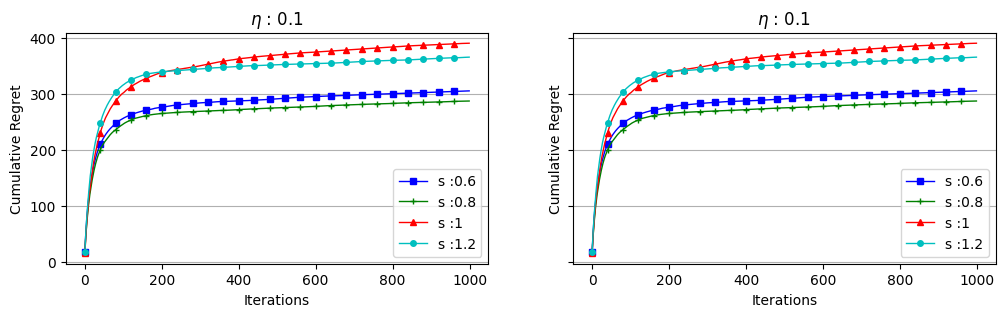

In [370]:
result_folder ='results_bandit_adap/'
files = [file for file in os.listdir(result_folder) if file.endswith('.pkl')]

lr_tup= (0.00005,0.0015,0.005,0.015,0.05)
s_tup= (0.6,0.8,1,1.25,1.5)

lr_tup= (0.01,0.025,0.05,0.1)
s_tup= (0.6,0.8,1,1.2)

lr_tup= (0.1,0.1)
s_tup= (0.6,0.8,1,1.2)


file_dict = order_file_names(files,lr_tup,s_tup)

style = ['b-s','r-s','g-s','m-s','b-*','r-*','g-*','m-*','b-s','r-s','g-s','m-s','b-*','r-*','g-*','m-*']
markers=['s','+','^','o','v','2']
colors = ['b','g','r','c','m']

# fig, axs = plt.subplots(1, 5,figsize=(10, 8),sharey=True)
fig, axs = plt.subplots(1, len(lr_tup),figsize=(12, 3),sharey=True)
# fig, axs = plt.subplots(1, len(lr_tup),figsize=(12, 3))


for k,lr_val in enumerate(lr_tup):
    # file1= [file for file in files if file.find(f'lr:{lr_val}')>0]
    
    for idx,s in enumerate(s_tup):
        file = file_dict[f'{lr_val}'][f'{s}']
        results,config = read_file(result_folder,file)

        regret = results['regret']
        actions = results['actions']
        sampled_points = results['points']
        lr = config['lr']
        s = config['s']
        # regret = compute_regret(actions,sampled_points)


        st = colors[idx]+'-'+markers[idx]
        label = f's :{s}'
        # ax1[0].plot(iterations,avg_grad_norm_pt,st,linewidth=1, markersize=4, markevery=20,label = label)
        reg = np.cumsum(regret)
        axs[k].plot(reg,st,linewidth=1, markersize=4, markevery=40,label = label)
        axs[k].set_title(f'$\eta$ : {lr_val}')
        axs[k].legend()
        axs[k].set_xlabel('Iterations')
        axs[k].set_ylabel('Cumulative Regret')
        axs[k].grid(True,axis='y')
        # plt.title(f's = {s:.2f} Regret : {regret.sum():.4f}')

    # plt.title(lr_val)
    # plt.legend()
plt.savefig('figures/regret_bandit_sphere_1.pdf', format="pdf", bbox_inches="tight")
plt.show()



Learning Rate:1


/var/folders/g2/8d9n981s0qx9hvdvf16d48v80000gp/T/ipykernel_14351/3533723503.py:17: RuntimeWarning: invalid value encountered in divide
  direction = np.where(sin_theta == 0, 0, direction / sin_theta)
/var/folders/g2/8d9n981s0qx9hvdvf16d48v80000gp/T/ipykernel_14351/3533723503.py:17: RuntimeWarning: divide by zero encountered in divide
  direction = np.where(sin_theta == 0, 0, direction / sin_theta)


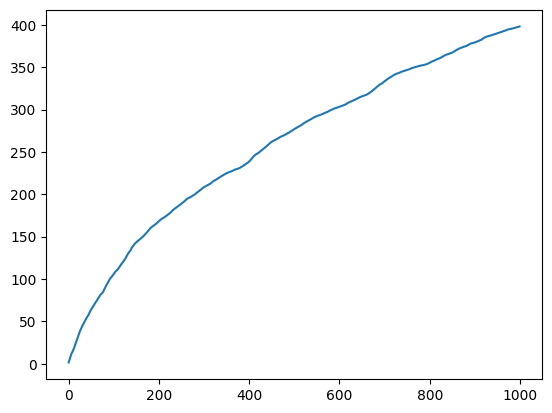

In [382]:
T=1000
n_agents = 50
dim = 16
k_nb = 10
np.random.seed(0)
r1 = 0.225*np.pi # run this 0.25 and lr 3e-1
r2 = np.pi/16
delta = 0.25*np.pi - r1
adaptive = 'True'

lr1 = 1
s = 1


W = generate_ring_communication_matrix(n_agents, k_nb)
base_agents,global_base = sim_generate_base(n_agents,dim,r1)
dataset =generate_dataset(T,base_agents,global_base,r1,r2)

# lr = lr1/np.sqrt(T)
lr =lr1
print(f'Learning Rate:{lr}')       
config={'T':T,'n_agents':n_agents,'k_nb':k_nb,'dim':dim,'r1':r1,'r2':r2,'lr':lr,'s':s,'W':W,'adap':adaptive,'delta':delta,'dataset':dataset,'base_agents':base_agents,'global_base':global_base}
result = run_sim_config(config)

plt.figure()
plt.plot(np.cumsum(result['regret']))

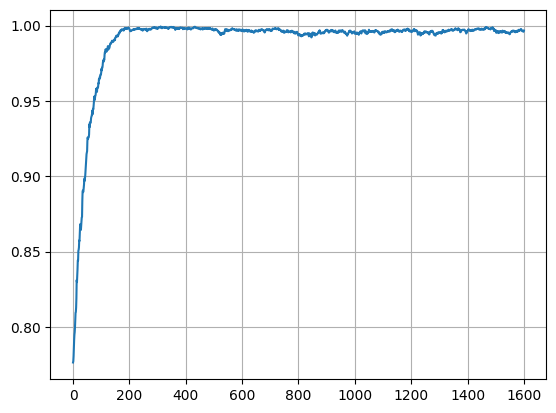

In [316]:
ag_idx=2
state_ag = result['actions'][:,ag_idx,:]
dataset = result['actions']

all_points = dataset.reshape(-1,dim)
global_opt=compute_frechet_mean(all_points,max_iter=100, tol=1e-6, step_size=1).squeeze()

dists = state_ag@global_opt

plt.figure()

plt.plot(dists)
plt.grid()